In [3]:
%pylab inline
import pandas as pd
import threading

Populating the interactive namespace from numpy and matplotlib


In [4]:
threading.current_thread().ident

139994710255424

In [5]:
np.__version__

'1.13.2'

In [6]:
def make_train_test(DIR="../input/"):
    train=pd.read_csv(DIR+"/train2_2016_2017_withy.csv",index_col=0)
    test=pd.read_csv(DIR+"/test2_2016_2017_withy.csv",index_col=0)    
    labels=train['logerror']
    train=train.drop("logerror",axis=1)
    test=test.drop("logerror",axis=1)
    assert (train.columns==test.columns).all()
    return train.astype(np.float32),labels.astype(np.float32),test.astype(np.float32)

In [7]:
%time train,labels,test=make_train_test()
train.shape,labels.shape,test.shape

CPU times: user 1min 17s, sys: 20.3 s, total: 1min 38s
Wall time: 1min 38s


((167888, 112), (167888,), (5970434, 112))

In [8]:
test.isnull().mean().mean()

0.698584313253322

In [9]:
train.values.nbytes/1024**2.,test.values.nbytes/1024.**2

(71.7294921875, 2550.8446044921875)

In [10]:
set(train['year']),set(train['month'])

({2016.0, 2017.0},
 {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0})

In [11]:
test['year'].value_counts(),test['month'].value_counts()

(Series([], Name: year, dtype: int64), Series([], Name: month, dtype: int64))

In [12]:
test['year']=test.index.map( lambda u: 2016 if u%10==6 else 2017).astype(np.float32)

In [13]:
test['year'].value_counts(),test['month'].value_counts()

(2017.0    2985217
 2016.0    2985217
 Name: year, dtype: int64, Series([], Name: month, dtype: int64))

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
import cPickle as pickle
import socket

In [15]:
def get_module():
    modulename='lightgbm'
    if modulename not in sys.modules:
        sys.path.insert(0, '/home/spark/software/lz/tmp/a/z/third/LightGBM/python-package/build/lib/') 
        import lightgbm
    if modulename not in sys.modules:
        raise Exception("module not found")
    m=sys.modules[modulename]
    print m.__version__
    assert m.__file__.startswith("/home/spark/software/lz/tmp/a/z/third"), m.__file__
    return  m, "{}_{}".format(socket.gethostname(),threading.current_thread().ident)
        

In [16]:
files='/tmp/c/lgb_fair /tmp/c/lgb_huber /tmp/c/lgb_regression_l1 /tmp/c/lgb_regression_l1f1 /tmp/c/lgb_regression_l1f2 /tmp/c/lgb_regression_l1f4 /tmp/c/lgb_regression_l1f6'.split(" ")
files=[ u.split("/")[-1] for u in files]
files,len(files)

(['lgb_fair',
  'lgb_huber',
  'lgb_regression_l1',
  'lgb_regression_l1f1',
  'lgb_regression_l1f2',
  'lgb_regression_l1f4',
  'lgb_regression_l1f6'],
 7)

In [17]:
filename=files[0]
filename

'lgb_fair'

In [18]:
import os
memory = '20g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

In [19]:
import findspark
findspark.init()

In [20]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf()
conf.set('spark.executor.cores',1)
conf.set('spark.executor.instances',3) 
conf.set('spark.speculation','true') 
conf.set('spark.driver.memory','30G') 
conf.set('spark.executor.memory','20G') 

#conf.set('spark.cores.max',15)     
conf.setAppName("spark")
conf.setMaster("spark://192.168.0.11:7077")
#conf.setMaster("local")

In [21]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc=spark.sparkContext

In [22]:
len(test.values),test.values.nbytes/1024.0**2

(5970434, 2550.8446044921875)

In [23]:
tests=[test.iloc[:1000000],test.iloc[1000000:2000000],
       test.iloc[2000000:3000000],test.iloc[3000000:4000000]
       ,test.iloc[4000000:5000000],test.iloc[5000000:6000000]]

In [24]:
np.sum([len(u) for u in tests]),[u.values.nbytes/1024.**2 for u in tests]

(5970434,
 [427.24609375,
  427.24609375,
  427.24609375,
  427.24609375,
  427.24609375,
  414.6141357421875])

In [25]:
def load_models(filename):
    while 1:
        tmp=sc.parallelize(range(1000),1000)
        ips=tmp.map(lambda u:  get_module()[1]).collect()
        print len(set(ips)),
        if len(set(ips))==57:
            break
    def g(u):
        param=u[0]
        score=u[1]
        lst=u[2]
        np.random.shuffle(lst)
        lst=lst[:3]
        return param,score,pickle.dumps(lst)
    models=sc.pickleFile('/tmp/c/'+filename).map(lambda u: g(u)).cache()
    print models.count()
    return models

In [26]:
data=[sc.broadcast(df) for df in tests]

In [27]:
def run1(models_str):
    cat=get_module()[0]
    models=pickle.loads(models_str)
    return [ m.best_iteration    for m in models]

In [28]:
import datetime
print datetime.datetime.now()

2017-10-10 14:10:27.146849


In [29]:
def run_once(models_str):
    cat=get_module()[0]
    df=pd.concat([u.value for u in data],axis=0).copy()
    models=pickle.loads(models_str)
    preds={}
    for month in [10,11,12]:
        df['month']=month
        d_test =   (df.values)
        pred=0
        for m in models:
            print "start at", datetime.datetime.now()
            pred=pred+m.predict(d_test,num_iteration=m.best_iteration)
            print "end at", datetime.datetime.now()
        pred=pred/float(len(models))
        pred=pred.astype(np.float32)
        preds[month]=pred
    return preds

In [30]:
models=load_models(filename)

57 95


In [31]:
modelsizes=models.map(lambda u: run1(u[2])).flatMap(lambda u: u).collect()  

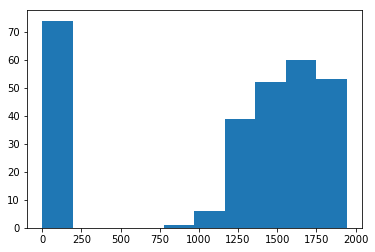

In [32]:
plt.hist(modelsizes);

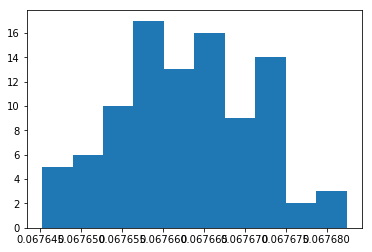

95 0.0676627987497


In [33]:
scores=models.map(lambda u: u[1]).collect()
plt.hist(scores);plt.show()
print len(scores),np.mean(scores)


In [34]:
390*10*3/3600.

3.25

In [35]:
3.25*95/19.

16.25

In [36]:
13*5*6

390

In [37]:
predfile="/tmp/c/"+filename+"_preds" 
!hadoop fs -rmr {predfile}

rmr: DEPRECATED: Please use 'rm -r' instead.
17/10/10 14:14:49 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /tmp/c/lgb_fair_preds


In [ ]:
this_pred=models.map(lambda u: run_once(u[2]))  

In [ ]:
this_pred.saveAsPickleFile(predfile)

In [ ]:
sc.stop()